<a href="https://colab.research.google.com/github/devpatat/ML_Projects/blob/master/Comparison_between_different_classifiers_on_Important_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [ ]:
#to ignore unnecessory warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#we need to install catboost first as it's not present by default.
!pip install catboost

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from scipy.stats import norm

from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold,KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from __future__ import division
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# visualization
import seaborn as sns 


plt.rcParams['figure.figsize'] = (10,4) 
#plt.rcParams['axes.titlesize'] = 'large'


## Importing Data

In [ ]:
data = pd.read_csv("data.csv")
X = data.iloc[:,1:]  #independent columns
y = data.iloc[:,0]    #target column i.e price range

## Feature Selection



### Select Kbest

In [ ]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

              Specs          Score
23       area_worst  112598.431564
3         area_mean   53991.655924
13          area_se    8758.504705
22  perimeter_worst    3665.035416
2    perimeter_mean    2011.102864
20     radius_worst     491.689157
0       radius_mean     266.104917
12     perimeter_se     250.571896
21    texture_worst     174.449400
1      texture_mean      93.897508


### TreeClassifier

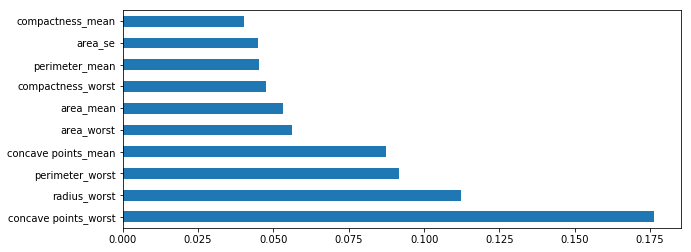

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Correlation Matrix

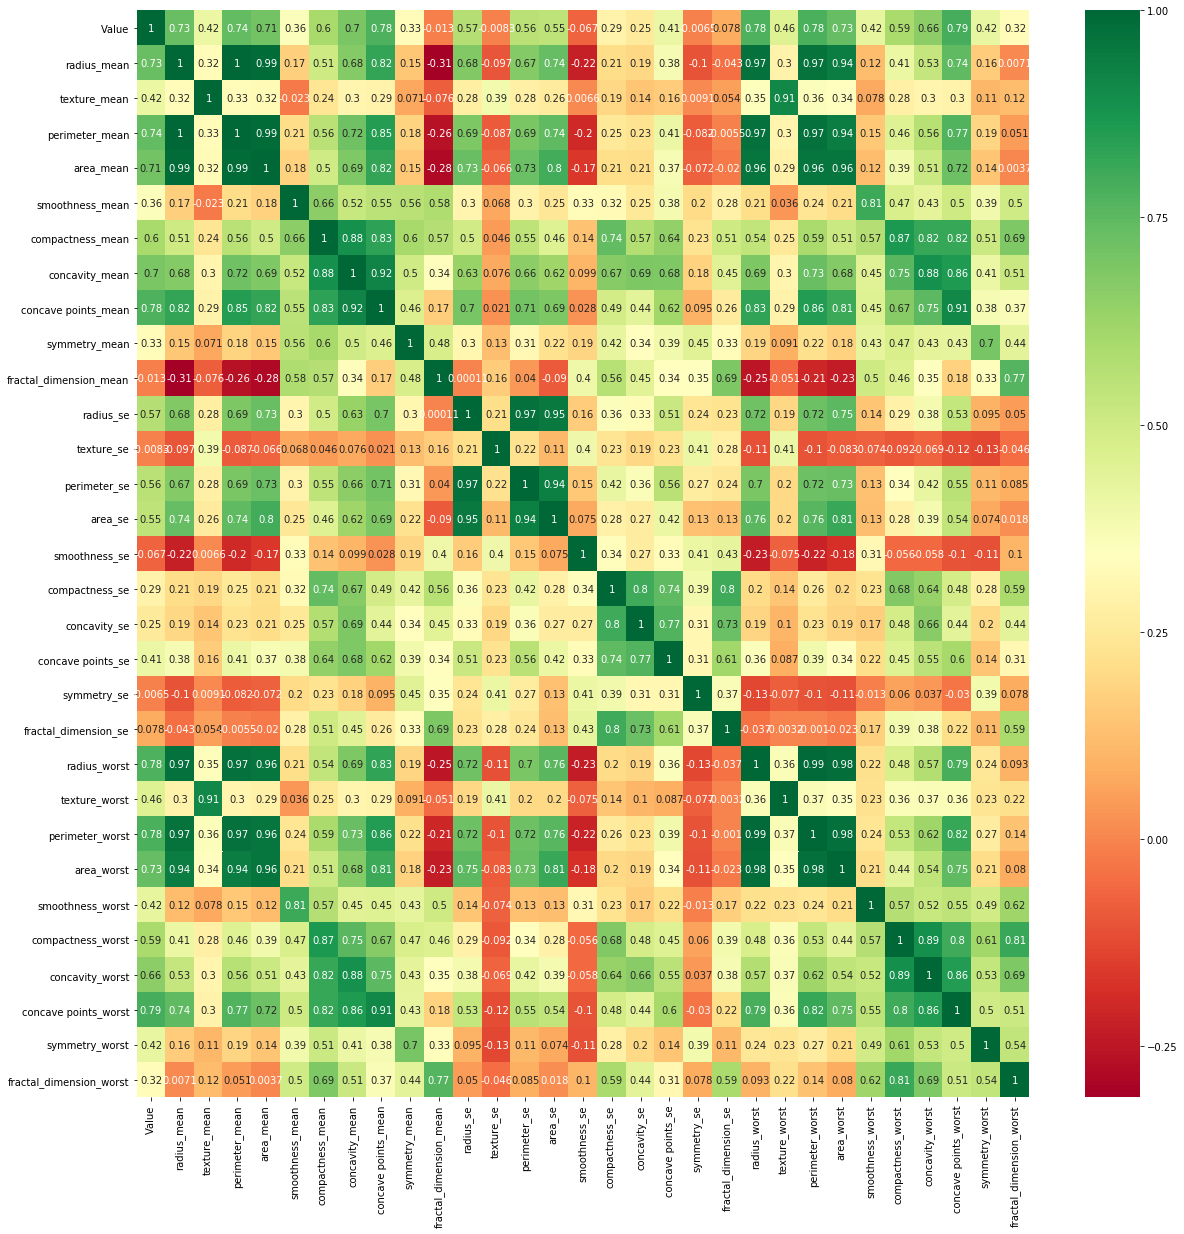

In [ ]:
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Have a look at the top row "Value" that shows correlation with other feature also.

## Implemetationn of Models
Now it is time to create some models of the data and estimate their accuracy on unseen data. Here is what we are going to cover in this step:
1. Separate out a validation dataset.
2. Setup the test harness to use 10-fold cross validation.
3. Build different models  
4. Select the best model

Also, from now on we'll use another dataset that contains only important features that are decided using above methods and citing research papers.

In [ ]:
#load data
data = pd.read_csv('imp_feat.csv', index_col=False)
#data.drop('Unnamed: 0',axis=1, inplace=True)

# Split-out validation dataset
array = data.values
X = array[:,1:]
y = array[:,0]

# Divide records in training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

#transform the class labels from their original string representation (M and B) into integers
le = LabelEncoder()
y = le.fit_transform(y)

## Evaluate Algorithms: Baseline

In [ ]:
data['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [ ]:
# Spot-Check Algorithms
models = []
models.append(( 'LR' , LogisticRegression()))
models.append(( 'LDA' , LinearDiscriminantAnalysis()))
models.append(( 'KNN' , KNeighborsClassifier()))
models.append(( 'CART' , DecisionTreeClassifier()))
models.append(( 'NB' , GaussianNB()))
models.append(( 'SVM' , SVC()))
models.append(( 'CB' , CatBoostClassifier( custom_loss=['Accuracy'], random_seed=42, logging_level='Silent')))
models.append(( 'NN' , MLPClassifier( activation='tanh', solver='lbfgs', max_iter=50000)))

# Test options and evaluation metric
num_folds = 10
num_instances = len(X_train)
seed = 7 
scoring =  'accuracy'

# Test options and evaluation metric
num_instances = len(X_train)
seed = 7 
scoring =  'accuracy'
results = []
names = []
kfold = KFold()
display("Model:  Accuracy  Std")
for name, model in models:
 cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
 results.append(cv_results)
 names.append(name)
 msg = "%s:\t%.2f%s\t(%f)" % (name, cv_results.mean()*100,"%", cv_results.std())
 print(msg)

'Model:  Accuracy  Std'

LR:	92.97%	(0.021541)
LDA:	95.23%	(0.015364)
KNN:	90.70%	(0.007270)
CART:	92.97%	(0.012597)
NB:	95.23%	(0.003467)
SVM:	60.30%	(0.030918)
CB:	96.99%	(0.012232)
NN:	95.98%	(0.009353)


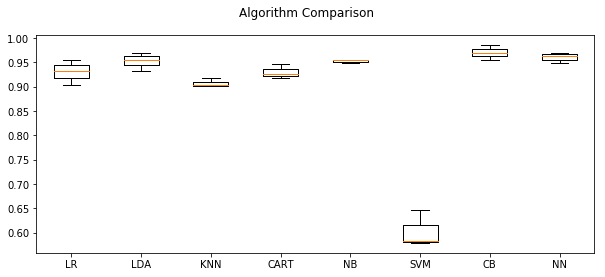

In [ ]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle( 'Algorithm Comparison' )
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Observation
> The results show a similar tight distribution for all classifiers except SVM which is encouraging, suggesting low variance. The poor results for SVM are surprising.





##Evaluate Algorithms: Standardize Data

In [ ]:
# Standardize the dataset
pipelines = []
pipelines.append(( 'ScaledLR' , Pipeline([( 'Scaler' , StandardScaler()),( 'LR' ,
    LogisticRegression())])))
pipelines.append(( 'ScaledLDA' , Pipeline([( 'Scaler' , StandardScaler()),( 'LDA' ,
    LinearDiscriminantAnalysis())])))
pipelines.append(( 'ScaledKNN' , Pipeline([( 'Scaler' , StandardScaler()),( 'KNN' ,
    KNeighborsClassifier())])))
pipelines.append(( 'ScaledCART' , Pipeline([( 'Scaler' , StandardScaler()),( 'CART' ,
    DecisionTreeClassifier())])))
pipelines.append(( 'ScaledNB' , Pipeline([( 'Scaler' , StandardScaler()),( 'NB' ,
    GaussianNB())])))
pipelines.append(( 'ScaledSVM' , Pipeline([( 'Scaler' , StandardScaler()),( 'SVM' , SVC())])))
pipelines.append(( 'ScaledCB' , Pipeline([( 'Scaler' , StandardScaler()),('CB' , CatBoostClassifier( custom_loss=['Accuracy'],random_seed=42,logging_level='Silent'))])))

pipelines.append(( 'ScaledNN' , Pipeline([( 'Scaler' , StandardScaler()),( 'NN' ,MLPClassifier( activation='tanh', solver='lbfgs', max_iter=50000))])))

results = []
names = []
display("Model    Accuracy    Std")
for name, model in pipelines:
  kfold = KFold()
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold,
      scoring=scoring)
  results.append(cv_results)
  names.append(name)
  
  msg = "%s:\t%.2f%s\t(%f)" % (name, cv_results.mean()*100,"%", cv_results.std())
  print(msg)

'Model    Accuracy    Std'

ScaledLR:	97.74%	(0.006093)
ScaledLDA:	95.23%	(0.015364)
ScaledKNN:	96.48%	(0.007036)
ScaledCART:	93.47%	(0.014016)
ScaledNB:	95.48%	(0.006023)
ScaledSVM:	96.48%	(0.003437)
ScaledCB:	96.99%	(0.012232)
ScaledNN:	95.98%	(0.009297)


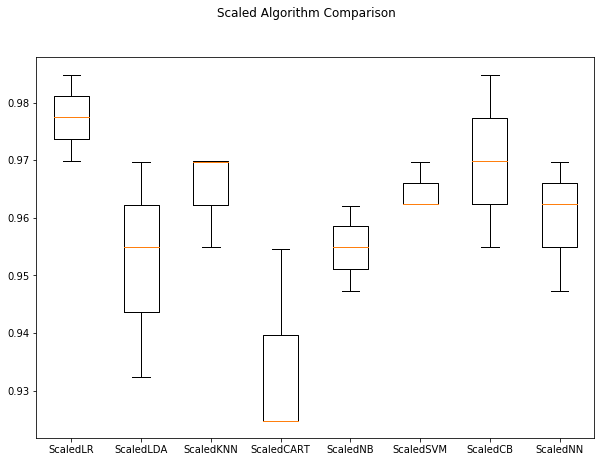

In [ ]:
# Compare Algorithms
fig = plt.figure(figsize=[10,7])
fig.suptitle( 'Scaled Algorithm Comparison' )
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

#### Observations
> The results show that standardization of the data has lifted the skill of few models to greater accuracy.



## Algorithm Tuning
In this section we investigate tuning the parameters for three algorithms that show promise from the spot-checking in the previous section: LR, LDA and SVM.



### SVC

In [ ]:
#Make Support Vector Classifier Pipeline
pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA(n_components=3)),
                     ('clf', SVC(probability=True, verbose=False))])

#Fit Pipeline to training Data
pipe_svc.fit(X_train, y_train)

#print('--> Fitted Pipeline to training Data')

scores = cross_val_score(estimator=pipe_svc, X=X_train, y=y_train, cv=10, n_jobs=1, verbose=0)
print('--> Model Training Accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

#Tune Hyperparameters
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,'clf__kernel': ['linear']},
              {'clf__C': param_range,'clf__gamma': param_range,
               'clf__kernel': ['rbf']}]
gs_svc = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=1)
gs_svc = gs_svc.fit(X_train, y_train)
y_pred = gs_svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
#print('--> Tuned Parameters Best Score: ',gs_svc.best_score_)
#print('--> Best Parameters: \n',gs_svc.best_params_)

--> Model Training Accuracy: 0.952 +/- 0.033
[[116   0]
 [  4  51]]


### k-NN
 For your standard k-NN implementation, there are two primary hyperparameters that you’ll want to tune:

* The number of neighbors k.
* The distance metric/similarity function.

Both of these values can dramatically affect the accuracy of your k-NN classifier. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

pipe_knn = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA(n_components=2)),
                     ('clf', KNeighborsClassifier())])
            
#Fit Pipeline to training Data
pipe_knn.fit(X_train, y_train) 

scores = cross_val_score(estimator=pipe_knn, 
                         X=X_train, 
                         y=y_train, 
                         cv=10,
                         n_jobs=1)
print('--> Model Training Accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

#Tune Hyperparameters
param_range = range(1, 31)
param_grid = [{'clf__n_neighbors': param_range}]
# instantiate the grid
grid = GridSearchCV(estimator=pipe_knn, 
                    param_grid=param_grid, 
                    cv=10, 
                    scoring='accuracy')
gs_knn = grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print('--> Tuned Parameters Best Score: ',gs_knn.best_score_)
print('--> Best Parameters: \n',gs_knn.best_params_)

--> Model Training Accuracy: 0.957 +/- 0.032
[[116   0]
 [  8  47]]
('--> Tuned Parameters Best Score: ', 0.964824120603015)
('--> Best Parameters: \n', {'clf__n_neighbors': 30})


### Catboost

We'll have to manually update the param value in here

In [ ]:
pipe = Pipeline([('scl', StandardScaler()),
                    
                     ('clf', CatBoostClassifier( custom_loss=['Accuracy'],
    logging_level='Silent',iterations=700,learning_rate= 0.01,
    
    ))])
            
#Fit Pipeline to training Data
pipe.fit(X_train, y_train) 
y_pred = pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
scores = cross_val_score(estimator=pipe, 
                         X=X_train, 
                         y=y_train, 
                         cv=10,
                         n_jobs=1)
print('--> Model Training Accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

[[116   0]
 [  4  51]]
--> Model Training Accuracy: 0.965 +/- 0.020


### Finalize Model

In [ ]:
#Use best parameters
clf_svc = gs_svc.best_estimator_

#Get Final Scores
clf_svc.fit(X_train, y_train)
scores = cross_val_score(estimator=clf_svc,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('--> Final Model Training Accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

print('--> Final Accuracy on Test set: %.5f' % clf_svc.score(X_test,y_test))


--> Final Model Training Accuracy: 0.972 +/- 0.028
--> Final Accuracy on Test set: 0.97661


In [ ]:
clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

print("%s %.2f%s" % ("Accuracy:",accuracy_score(y_test, y_pred)*100,"%"))

Accuracy: 97.66%


## Confusion Matrix & Report

In [ ]:
cf_matrix =confusion_matrix(y_test, y_pred)

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

In [ ]:
labels=[]
for v1, v2, v3 in zip(group_names,group_counts,group_percentages):
  labels.append([v1 + "\n" +v2 +"\n" +v3] )

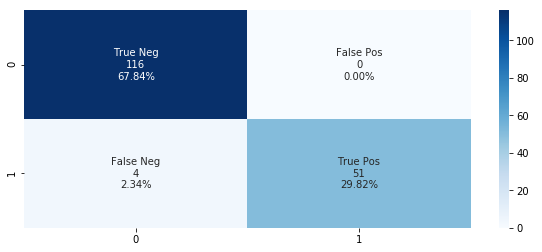

In [ ]:
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.97      1.00      0.98       116
           M       1.00      0.93      0.96        55

   micro avg       0.98      0.98      0.98       171
   macro avg       0.98      0.96      0.97       171
weighted avg       0.98      0.98      0.98       171

